# INDE 599 hw 5

# Chapter 15
*Go through Exercise '10. Bach Chorales' in AG's Ch. 15 notebook (Links to an external site.) and submit your favorite chorale among your generated ones in .wav format (10 pts).*

*Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out Google’s Coconet model, which was used for a nice Google doodle about Bach.*

In [3]:
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

131072/117661 [=================================] - 0s 0us/step


In [5]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [6]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [7]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [8]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [9]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [10]:
for index in range(3):
    play_chords(train_chorales[index])

Output hidden; open in https://colab.research.google.com to view.

Divine! :)

In order to be able to generate new chorales, we want to **train a model that can predict the next chord given all the previous chords**. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to **predict one note at a time**. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. **We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future**.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [11]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [12]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [13]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d (Conv1D)             (None, None, 32)          352       
                                                                 
 batch_normalization (BatchN  (None, None, 32)         128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 48)          3120      
                                                                 
 batch_normalization_1 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          6

Now we're ready to compile and train the model!

In [14]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 20s 38ms/step - loss: 1.8139 - accuracy: 0.5366 - val_loss: 4.2991 - val_accuracy: 0.0415
Epoch 2/20
98/98 [==============================] - 3s 34ms/step - loss: 0.8923 - accuracy: 0.7640 - val_loss: 4.3346 - val_accuracy: 0.0753
Epoch 3/20
98/98 [==============================] - 2s 22ms/step - loss: 0.7491 - accuracy: 0.7929 - val_loss: 3.7602 - val_accuracy: 0.1359
Epoch 4/20
98/98 [==============================] - 2s 20ms/step - loss: 0.6749 - accuracy: 0.8083 - val_loss: 2.9731 - val_accuracy: 0.1989
Epoch 5/20
98/98 [==============================] - 2s 20ms/step - loss: 0.6244 - accuracy: 0.8194 - val_loss: 2.7793 - val_accuracy: 0.3219
Epoch 6/20
98/98 [==============================] - 2s 20ms/step - loss: 0.5838 - accuracy: 0.8276 - val_loss: 1.4256 - val_accuracy: 0.5552
Epoch 7/20
98/98 [==============================] - 2s 20ms/step - loss: 0.5471 - accuracy: 0.8370 - val_loss: 0.7296 - val_accuracy: 0.7906
Epoch 8/20
9

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [15]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

34/34 [==============================] - 1s 15ms/step - loss: 0.6974 - accuracy: 0.8095


[0.697399377822876, 0.8094965815544128]

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

**Warning**: `model.predict_classes(X)` is deprecated. It is replaced with `np.argmax(model.predict(X), axis=-1)`.

In [16]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [17]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [18]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

Output hidden; open in https://colab.research.google.com to view.

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [19]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [20]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

Output hidden; open in https://colab.research.google.com to view.

In [21]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

Output hidden; open in https://colab.research.google.com to view.

In [22]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Output hidden; open in https://colab.research.google.com to view.

This superhot chorale is very scary lol.

In [24]:
new_chorale_v2_superhot = generate_chorale_v2(model, seed_chords, 56, temperature=3)
play_chords(new_chorale_v2_superhot, filepath="bach_superhot.wav")

Output hidden; open in https://colab.research.google.com to view.

In [28]:
seed_chords = test_chorales[0][:8]
play_chords(seed_chords, amplitude=0.2)

In [30]:
new_chorale_v2_newseedhot = generate_chorale_v2(model, seed_chords, 56, temperature=2)
play_chords(new_chorale_v2_newseedhot, filepath="bach_newseedhot.wav")

Output hidden; open in https://colab.research.google.com to view.

In [31]:
new_chorale_v2_newseedmedium = generate_chorale_v2(model, seed_chords, 56, temperature=1)
play_chords(new_chorale_v2_newseedmedium, filepath="bach_newseedmedium.wav")

Output hidden; open in https://colab.research.google.com to view.

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [23]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")

Output hidden; open in https://colab.research.google.com to view.

# Chapter 16
* Go through TensorFlow's text generation with an RNN tutorial (Links to an external site.) and submit your generated text of 1000 characters in Shakespearean style (10pts).
* (Bonus) Go through TensorFlow's neural machine translation with attention (Links to an external site.) and submit a labeled attention plot for translating a Spanish sentence '¡Sigue con el buen trabajo!' (10pts).
* (Bonus) Go through TensorFlow's classify text with BERT (Links to an external site.) and submit your model's score of any (truncated) user review of your favorite movie on IMDb (Links to an external site.). Please submit the review text you chose as input (5pts).

### Download the Shakespeare dataset

Change the following line to run this code on your own data.

In [68]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### Read the data

First, look in the text:

In [37]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [38]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [39]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Process the text

### Vectorize the text

Before training, you need to convert the strings to a numerical representation. 

The `tf.keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [40]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Now create the `tf.keras.layers.StringLookup` layer:

In [41]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

It converts from tokens to character IDs:

In [42]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Since the goal of this tutorial is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use `tf.keras.layers.StringLookup(..., invert=True)`.  

Note: Here instead of passing the original vocabulary generated with `sorted(set(text))` use the `get_vocabulary()` method of the `tf.keras.layers.StringLookup` layer so that the `[UNK]` tokens is set the same way.

In [43]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

In [44]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

You can `tf.strings.reduce_join` to join the characters back into strings. 

In [45]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [46]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task you're training the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [47]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [48]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [49]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [50]:
seq_length = 100


The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [51]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [52]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training you'll need a dataset of `(input, label)` pairs. Where `input` and 
`label` are sequences. At each time step the input is the current character and the label is the next character. 

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [53]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [54]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [55]:
dataset = sequences.map(split_input_target)

In [56]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Create training batches

You used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [57]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Build The Model

This section defines the model as a `keras.Model` subclass (For details see [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)). 

This model has three layers:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

In [58]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [59]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [60]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](images/text_generation_training.png)

Note: For training you could use a `keras.Sequential` model here. To  generate text later you'll need to manage the RNN's internal state. It's simpler to include the state input and output options upfront, than it is to rearrange the model architecture later. For more details see the [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [61]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [62]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [63]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [64]:
sampled_indices

array([10, 61, 35, 21, 53, 42, 53, 34, 56, 59, 45, 16, 35, 24, 39, 38, 13,
       11, 58, 42, 28, 42, 28, 21, 62, 47, 24, 52, 62, 53, 58,  4, 41, 32,
       55,  2,  2,  1, 52, 14, 65, 17, 52, 58, 49,  0, 14, 15, 12, 63, 46,
       28, 29,  3, 21,  5, 50,  7, 31, 17, 60, 38, 34, 41, 59, 51, 37, 11,
       39, 28, 55, 26, 58, 31, 45, 21, 60, 10, 20,  8, 35, 31, 19, 34,  3,
        9, 48, 28, 20, 56, 30,  3, 17, 41, 33, 53, 52, 65, 59, 31])

Decode these to see the text predicted by this untrained model:

In [65]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'own, his forehead, nay, the valley,\nThe pretty dimples of his chin and cheek,\nHis smiles,\nThe very m'

Next Char Predictions:
 b'3vVHncnUqtfCVKZY?:scOcOHwhKmwns$bSp  \nmAzDmsj[UNK]AB;xgOP!H&k,RDuYUbtlX:ZOpMsRfHu3G-VRFU!.iOGqQ!DbTnmztR'


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the `from_logits` flag.


In [66]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [72]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.191069, shape=(), dtype=float32)


A newly initialized model shouldn't be too sure of itself, the output logits should all have similar magnitudes. To confirm this you can check that the exponential of the mean loss is approximately equal to the vocabulary size. A much higher loss means the model is sure of its wrong answers, and is badly initialized:

In [73]:
tf.exp(example_batch_mean_loss).numpy()

66.09342

Configure the training procedure using the `tf.keras.Model.compile` method. Use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [74]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [75]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [76]:
EPOCHS = 20

In [77]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 13s 58ms/step - loss: 2.7276
Epoch 2/20
172/172 [==============================] - 11s 60ms/step - loss: 1.9985
Epoch 3/20
172/172 [==============================] - 11s 57ms/step - loss: 1.7200
Epoch 4/20
172/172 [==============================] - 11s 55ms/step - loss: 1.5587
Epoch 5/20
172/172 [==============================] - 11s 56ms/step - loss: 1.4579
Epoch 6/20
172/172 [==============================] - 11s 58ms/step - loss: 1.3884
Epoch 7/20
172/172 [==============================] - 13s 60ms/step - loss: 1.3358
Epoch 8/20
172/172 [==============================] - 11s 58ms/step - loss: 1.2913
Epoch 9/20
172/172 [==============================] - 11s 56ms/step - loss: 1.2504
Epoch 10/20
172/172 [==============================] - 11s 56ms/step - loss: 1.2117
Epoch 11/20
172/172 [==============================] - 11s 55ms/step - loss: 1.1725
Epoch 12/20
172/172 [==============================] - 11s 56ms/step - loss: 1.1315
E

## Generate text

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

To generate text the model's output is fed back to the input.

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.


The following makes a single step prediction:

In [78]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [79]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [80]:
import time

start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
You lark, of that, if thou canst give:
Romeo cries after what life and all are we
At sitter heart? how now our friends there lies dead!
They do assure my voice of too ragged:
Then meet me speak.

Clown:
Come to me: good my lord, will love the crown,
To think our friends. Till, kind owes Kate;
For through you hope in hand to England's penitent
May pomp and followers for ever: where
I, underneath-she has been studding you danger.

upon her that must be king, 'madward's;
And not hear some cannot fly for sleep,
Condemn'd upon our freshs, and shall twelve winter's paw,
And woon--waving, through all the Lord Aumerle,
How soon content the pent; the sex
Both out of distrojes, showest beast,
With his absence he should not slept,
And Warwick stabb'd her earth, that shall stand, no friend? At we must confirm
The naves age, wife, let me entreat thy life;
Her widow Dakes a deed where bloody colours there.

KING EDWARD IV:
Lords, Exame, a most notting boy. We are they shall soon people away.


The easiest thing you can do to improve the results is to train it for longer (try `EPOCHS = 30`).

You can also experiment with a different start string, try adding another RNN layer to improve the model's accuracy, or adjust the temperature parameter to generate more or less random predictions.

If you want the model to generate text *faster* the easiest thing you can do is batch the text generation. In the example below the model generates 5 outputs in about the same time it took to generate 1 above. 

In [81]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nYet for this new shall beat down and for ang land.\n\nFirst Murderer:\nWe are three pun afterson: 'tis whist toward Earl of man!\n\nGREMIO:\nBy an irward coucasis coat, But man of slave,\nTo help me we'll complain us uncherrable.'\n\nKING LEWIS XI:\nWash fimishadies safety on the foe\nAs who about, weeping and can make force a day or match.\nSignior Gloucester's death, not Tonaworst head.\n\nSecond Most George you come:\nUnless they would departer'd, long consent to have\nBy many woes cat bad either woes your lord.\n\nCLIFFORD:\nYou advantages you, and, yours, all and in.\n\nDUCHESS OF YORK:\nHe shall be brought to hear some neighbours and Duke of York\nHaving the prefixed hour of his sister,\nNo other: I'll swear, Camillo, and what is like.\n\nDUKE OF AUMERLE:\nRomeo; why, march he wears? Is that is paste.\nYou word of the murderous villain faith.\nMost loving with my talk age, save meaning,\nOne pain is last, and break a foolish office.\n\nPALIS:\nDo you so? Wha

## Export the generator

This single-step model can easily be [saved and restored](https://www.tensorflow.org/guide/saved_model), allowing you to use it anywhere a `tf.saved_model` is accepted.

In [82]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets


In [83]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
You lark, of that, if thou canst give:
Romeo cries after what life and all are we
At sitter heart? 


## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.
It uses teacher-forcing which prevents bad predictions from being fed back to the model, so the model never learns to recover from mistakes.

So now that you've seen how to run the model manually next you'll implement the training loop. This gives a starting point if, for example, you want to implement _curriculum  learning_ to help stabilize the model's open-loop output.

The most important part of a custom training loop is the train step function.

Use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The basic procedure is:

1. Execute the model and calculate the loss under a `tf.GradientTape`.
2. Calculate the updates and apply them to the model using the optimizer.

In [84]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above implementation of the `train_step` method follows [Keras' `train_step` conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). This is optional, but it allows you to change the behavior of the train step and still use keras' `Model.compile` and `Model.fit` methods.

In [85]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [86]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [87]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 13s 58ms/step - loss: 2.6961


Or if you need more control, you can write your own complete custom training loop:

In [88]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1638
Epoch 1 Batch 50 Loss 2.0265
Epoch 1 Batch 100 Loss 1.9480
Epoch 1 Batch 150 Loss 1.8417

Epoch 1 Loss: 1.9763
Time taken for 1 epoch 12.32 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8237
Epoch 2 Batch 50 Loss 1.6925
Epoch 2 Batch 100 Loss 1.7083
Epoch 2 Batch 150 Loss 1.5992

Epoch 2 Loss: 1.6960
Time taken for 1 epoch 10.75 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5890
Epoch 3 Batch 50 Loss 1.5526
Epoch 3 Batch 100 Loss 1.5343
Epoch 3 Batch 150 Loss 1.5112

Epoch 3 Loss: 1.5369
Time taken for 1 epoch 10.62 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.5065
Epoch 4 Batch 50 Loss 1.3843
Epoch 4 Batch 100 Loss 1.4654
Epoch 4 Batch 150 Loss 1.4409

Epoch 4 Loss: 1.4400
Time taken for 1 epoch 10.41 sec
_____________________________________________________________________

# Chapter 17
* Go through TensorFlow's Intro to Autoencoders (Links to an external site.) and submit your result plot for the second example using noise_factor = 0.5. As for the third example, please submit a PDF of your notebook that shows your own model architecture (10pts).
* If you achieve a better test accuracy than the tutorial's model (i.e., 0.945), you will receive a bonus of 2 pts. 

## Import TensorFlow and other libraries

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [90]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [91]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [92]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [93]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0235 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [94]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

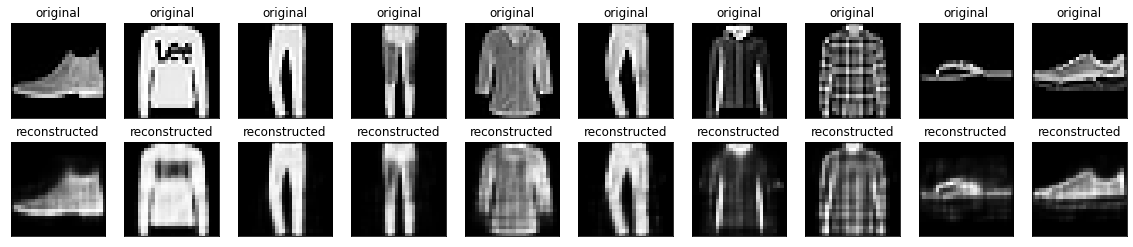

In [95]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [96]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [97]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [98]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


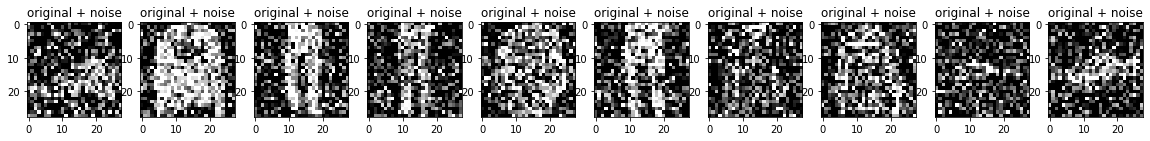

In [99]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [100]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [101]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [102]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0271 - val_loss: 0.0209
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0204 - val_loss: 0.0202
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0190 - val_loss: 0.0189
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0185 - val_loss: 0.0185
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0184 - val_loss: 0.0184
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0183 - val_loss: 0.0184
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0182 - val_loss: 0.0185
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.018

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [103]:
autoencoder.encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [104]:
autoencoder.decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [105]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

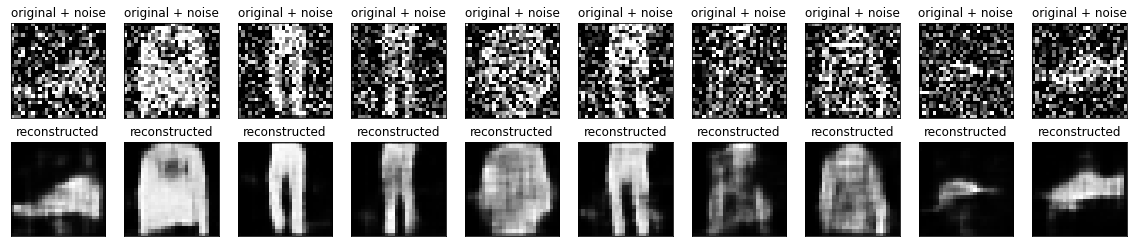

In [106]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [107]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [108]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [109]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [110]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

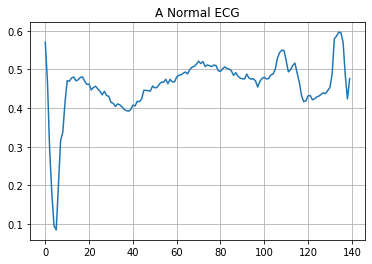

In [111]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

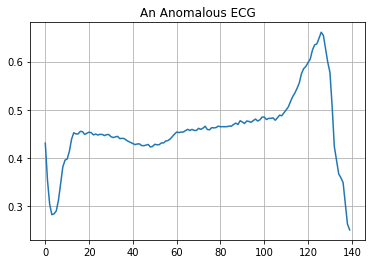

In [112]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [113]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Check the model structure:

In [124]:
autoencoder.encoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                4512      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
Total params: 5,176
Trainable params: 5,176
Non-trainable params: 0
_________________________________________________________________


In [125]:
autoencoder.decoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 140)               4620      
                                                                 
Total params: 5,308
Trainable params: 5,308
Non-trainable params: 0
_________________________________________________________________


In [114]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [115]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 35ms/step - loss: 0.0584 - val_loss: 0.0535
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0563 - val_loss: 0.0520
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0535 - val_loss: 0.0506
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0498 - val_loss: 0.0484
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0453 - val_loss: 0.0458
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0409 - val_loss: 0.0440
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0372 - val_loss: 0.0417
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0339 - val_loss: 0.0398
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0313 - val_loss: 0.0385
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0292 - val_loss: 0.0376
Epoch 11/20
5/5 [=================

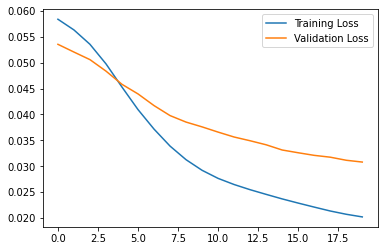

In [116]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

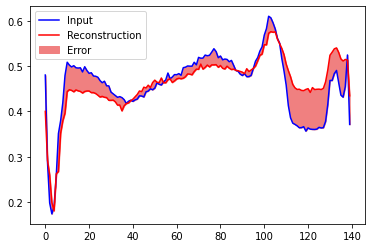

In [117]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

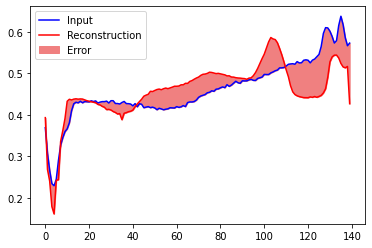

In [118]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

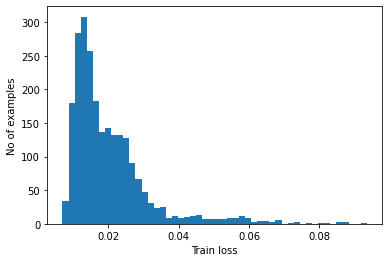

In [119]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [120]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.031187892


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

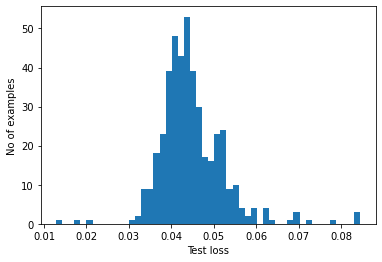

In [121]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [122]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [123]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.94
Precision = 0.9921259842519685
Recall = 0.9


# Chapter 17
* Go through TensorFlow's Deep Convolutional Generative Adversarial Network (DCGAN) (Links to an external site.) and submit your result GIF (10 pts).
* For a bonus of 2 pts, you may submit another GIF generated using the Fashion MNIST dataset (Links to an external site.).

### Setup

In [126]:
import tensorflow as tf

In [127]:
tf.__version__

'2.8.2'

In [128]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kcj7p7ps
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-kcj7p7ps
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179893 sha256=c1755e3c01082f556df67baeac1afeff8ae69cb5d4d04621d9d9226e31112c4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-w26lph2w/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [129]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [130]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [131]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [132]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [133]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [134]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

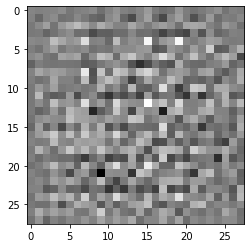

In [135]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [136]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [137]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00119896]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [138]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [139]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [140]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [141]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [142]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [143]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [144]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [145]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [146]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

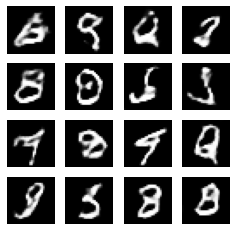

In [147]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [148]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [149]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

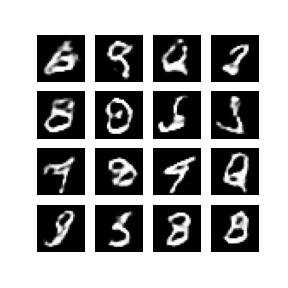

In [150]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [151]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


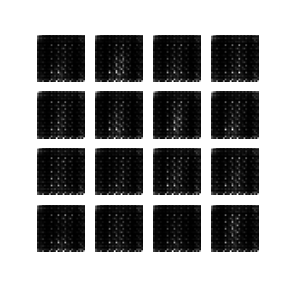

In [152]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)